   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 564.4 kB/s eta 0:00:00
Selecting previously unselected package fonts-noto-cjk.
(Reading database ... 126284 files and directories currently installed.)
Preparing to unpack .../fonts-noto-cjk_1%3a20220127+repack1-1_all.deb ...
Unpacking fonts-noto-cjk (1:20220127+repack1-1) ...
Setting up fonts-noto-cjk (1:20220127+repack1-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
データファイルを読み込んでいます...
SNe共分散行列の逆行列を計算中...
計算完了。
以前の実行ファイルが見つかりました: joint_sne_bao_R_early_prior_backend.h5。計算を再開します。
完了済みステップ数: 5717
残り 4283 ステップのMCMCサンプリングを実行します...


100%|██████████| 4283/4283 [8:57:10<00:00,  7.53s/it]


MCMCサンプリングが完了しました。

結果をプロットしています...


コーナープロットを 'corner_R_early_prior.png' として保存しました。


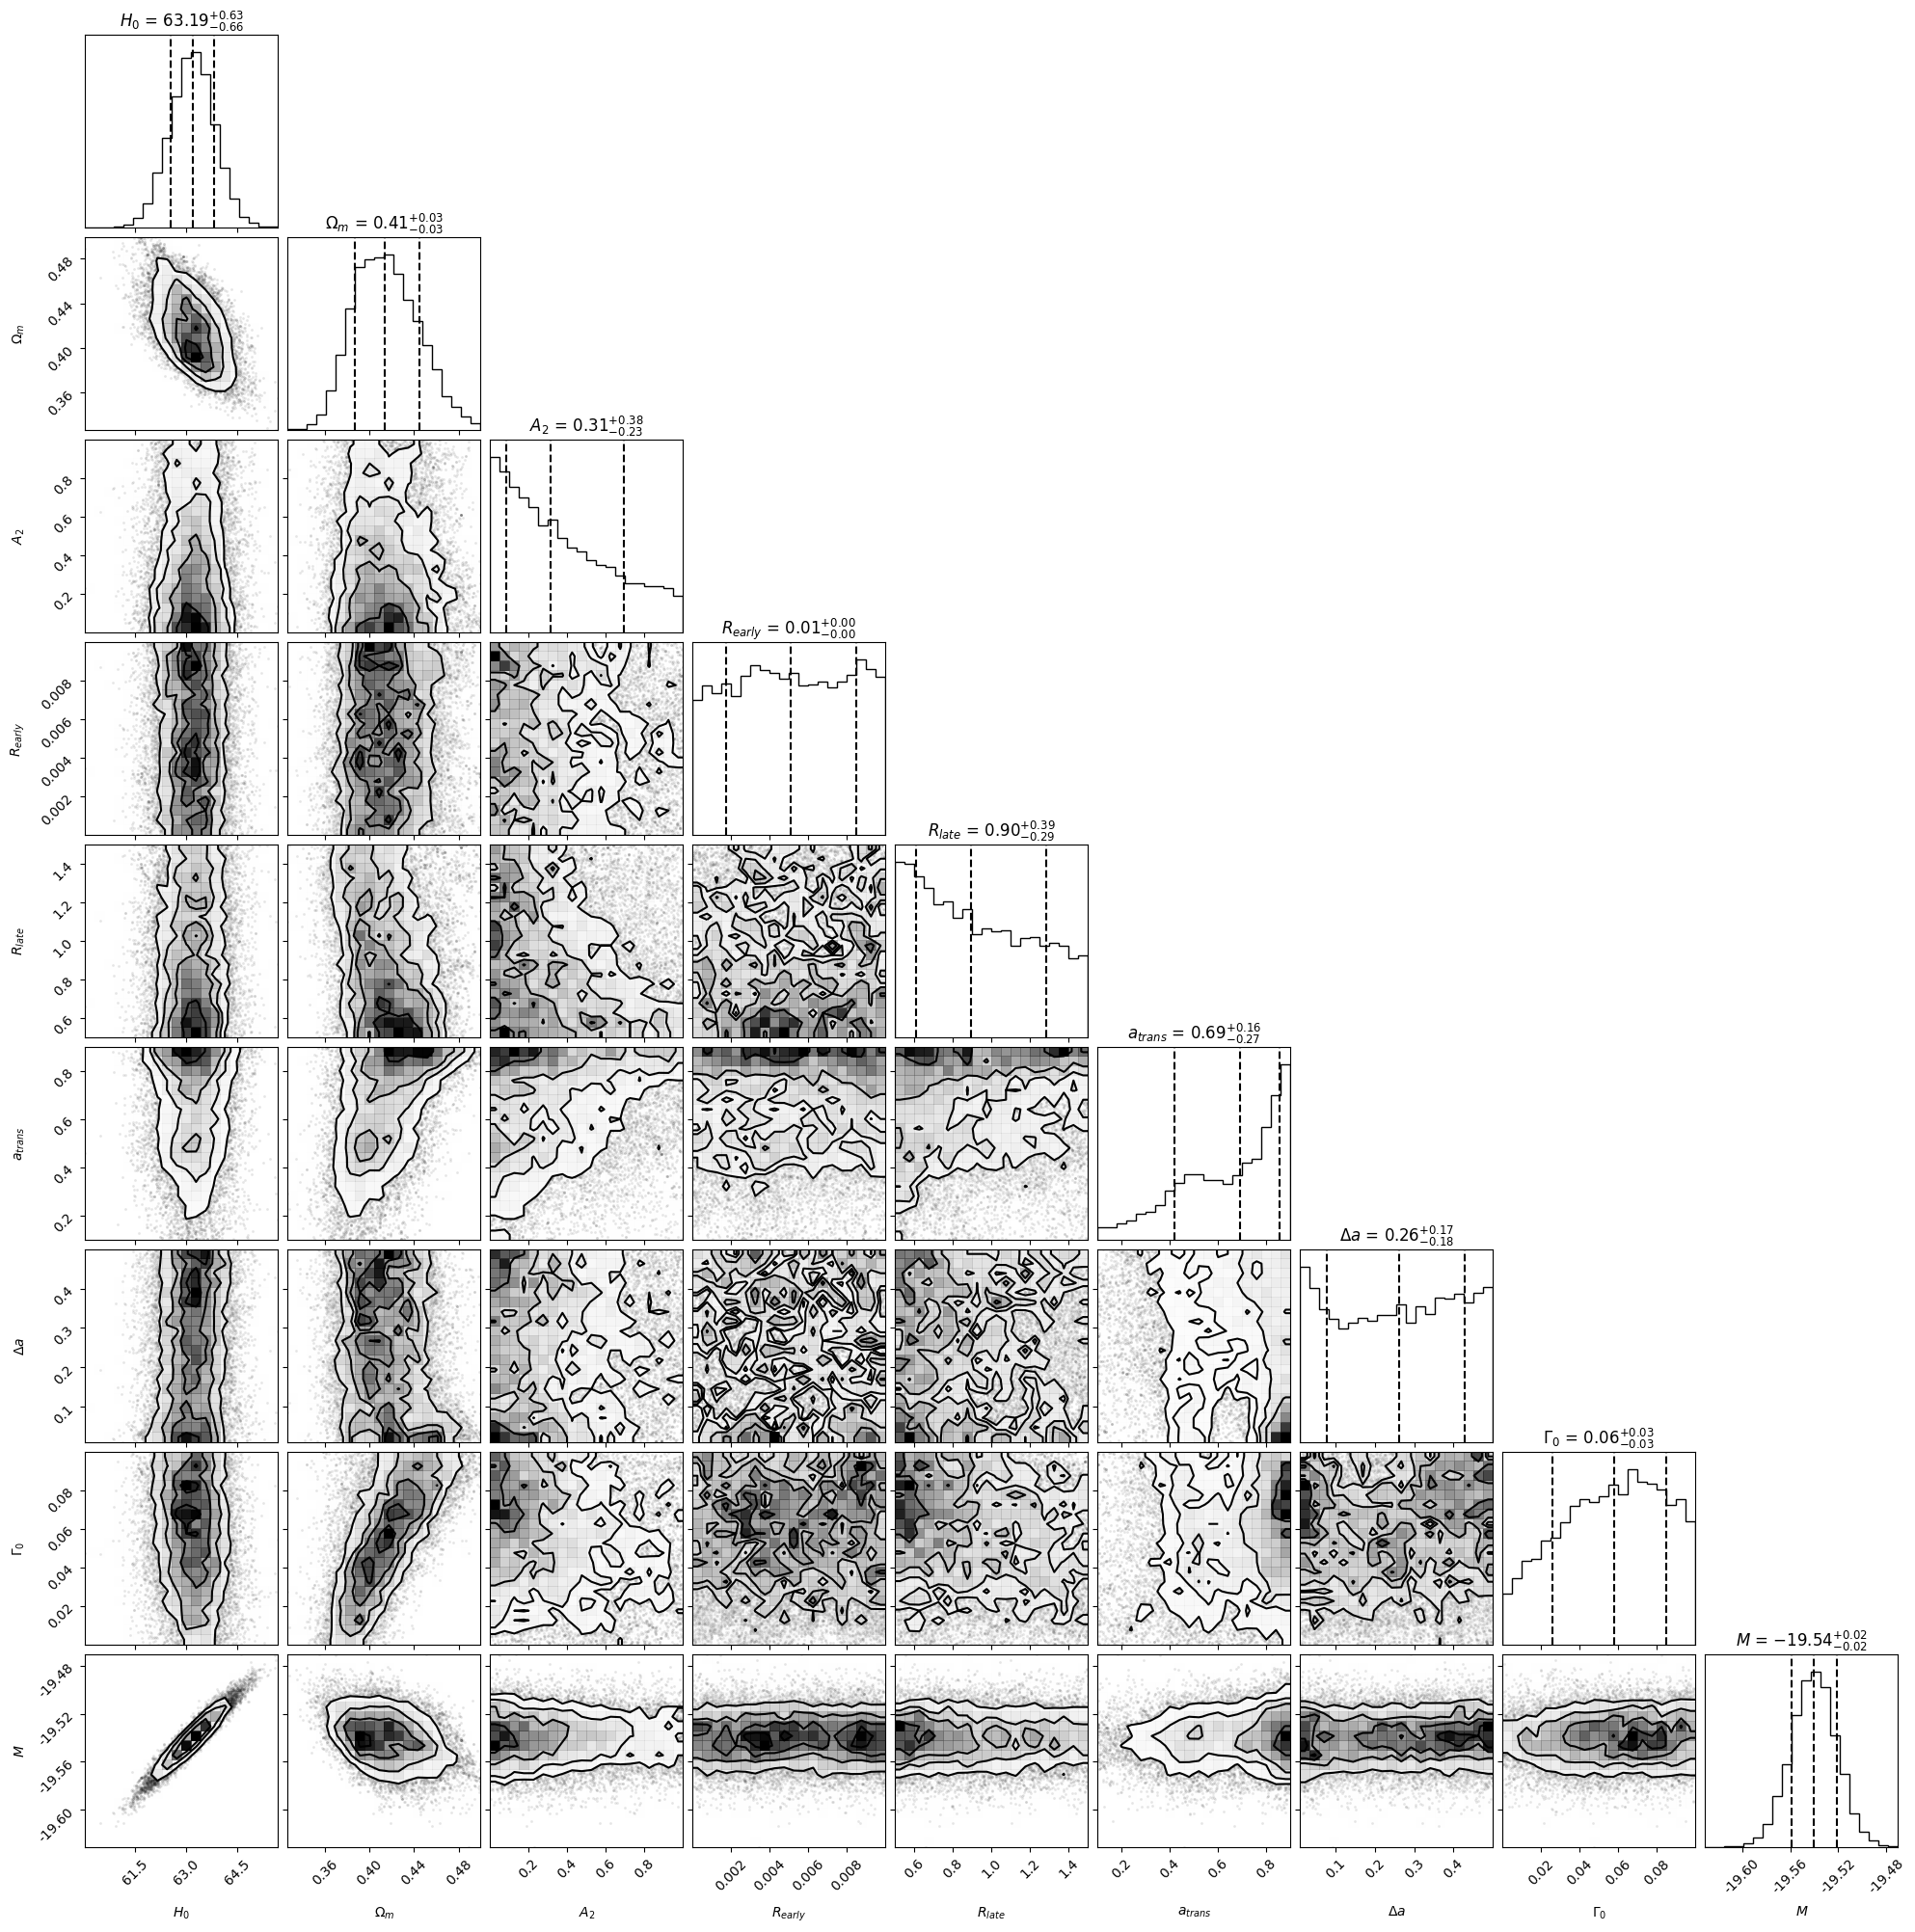


--- パラメータ推定結果 (SNe+BAO 統合解析, R_early事前分布あり) ---
$H_0$      = 63.1923 +0.6290 / -0.6617
$\Omega_m$ = 0.4137 +0.0313 / -0.0271
$A_2$      = 0.3118 +0.3806 / -0.2299
$R_{early}$ = 0.0051 +0.0034 / -0.0033
$R_{late}$ = 0.8950 +0.3902 / -0.2876
$a_{trans}$ = 0.6913 +0.1645 / -0.2723
$\Delta a$ = 0.2622 +0.1663 / -0.1838
$\Gamma_0$ = 0.0578 +0.0272 / -0.0319
$M$        = -19.5403 +0.0189 / -0.0187

パラメータ推定結果を 'mcmc_results_R_early_prior.txt' に保存しました。


In [1]:
# ===== Step 0: Install Required Libraries =====
# ===== ステップ0: 必要なライブラリのインストール =====
!pip install astropy emcee corner -q

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from scipy.integrate import quad
from astropy.coordinates import SkyCoord
from astropy import units as u
import emcee
import corner
from tqdm import tqdm
import os

# ===== Japanese Font Settings =====
# ===== 日本語フォント設定 =====
!apt-get -y install fonts-noto-cjk -qq
try:
    font_path = "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc"
    font_prop = fm.FontProperties(fname=font_path)
    plt.rcParams["font.family"] = font_prop.get_name()
except FileNotFoundError:
    print("日本語フォントが見つかりませんでした。デフォルトのフォントを使用します。")
plt.rcParams["axes.unicode_minus"] = False

# ===== Step 1: Load and Prepare Data =====
# ===== ステップ1: データの読み込みと準備 =====
print("データファイルを読み込んでいます...")
try:
    sne_data_file = 'Pantheon+SH0ES.dat'
    sne_cov_file = 'Pantheon+SH0ES_STAT+SYS.cov'
    pantheon_data = pd.read_csv(sne_data_file, sep='\\s+', comment='#')
    N_sne = len(pantheon_data)
    cov_matrix_flat = np.loadtxt(sne_cov_file, skiprows=1)
    cov_matrix = cov_matrix_flat.reshape((N_sne, N_sne))
    print("SNe共分散行列の逆行列を計算中...")
    C_inv_sne = np.linalg.inv(cov_matrix)
    print("計算完了。")
except FileNotFoundError:
    print("\n!!! エラー: データファイルが見つかりません。!!!")
    print("Colabの左側のファイルメニューから 'Pantheon+SH0ES.dat' と 'Pantheon+SH0ES_STAT+SYS.cov' をアップロードしてください。")
    # Stop execution if files are not found
    raise SystemExit

# 天球座標の計算
l_d = 264.02 * u.deg
b_d = 48.25 * u.deg
d_coord_galactic = SkyCoord(l=l_d, b=b_d, frame='galactic')
d_vector = d_coord_galactic.cartesian.xyz.value
sn_coords_icrs = SkyCoord(ra=pantheon_data['RA'], dec=pantheon_data['DEC'], unit='deg', frame='icrs')
sn_coords_galactic = sn_coords_icrs.galactic
n_vectors_sn = sn_coords_galactic.cartesian.xyz.value.T
pantheon_data['cos_theta'] = np.dot(n_vectors_sn, d_vector)

# BAOデータの準備
bao_data_list = [
    [0.70, 'DH', 180.0, 15.0, 19.33, 0.57], [0.70, 'DM', 180.0, 15.0, 17.86, 0.33],
    [1.48, 'DH', 195.0, 25.0, 13.23, 0.47], [1.48, 'DM', 195.0, 25.0, 30.21, 0.79],
    [0.50, 'DH', 190.0, 40.0, 23.39, 0.70], [0.50, 'DM', 190.0, 40.0, 14.05, 0.17],
    [0.90, 'DH', 210.0, 35.0, 17.58, 0.38], [0.90, 'DM', 210.0, 35.0, 22.01, 0.24],
    [1.60, 'DH', 170.0, 10.0, 12.39, 0.31], [1.60, 'DM', 170.0, 10.0, 32.11, 0.59]
]
bao_df = pd.DataFrame(bao_data_list, columns=['z', 'type', 'RA', 'DEC', 'value', 'error'])
bao_coords_icrs = SkyCoord(ra=bao_df['RA'], dec=bao_df['DEC'], unit='deg', frame='icrs')
bao_coords_galactic = bao_coords_icrs.galactic
n_vectors_bao = bao_coords_galactic.cartesian.xyz.value.T
bao_df['cos_theta'] = np.dot(n_vectors_bao, d_vector)

# ===== Step 2: Definition of Model and Likelihood Function =====
# ===== ステップ2: モデルと尤度関数の定義 =====
c_kms = 299792.458
r_d_fiducial = 147.09

def p2(ct): return 0.5 * (3 * ct**2 - 1)
def r_iso_transition_model(a, R_early, R_late, a_trans, delta_a):
    return R_late + (R_early - R_late) * 0.5 * (1 - np.tanh((a - a_trans) / delta_a))
def hubble_parameter_interaction(z, cos_theta, H0, Omega_m, A2, R_early, R_late, a_trans, delta_a, Gamma0):
    a = 1.0 / (1.0 + z)
    Omega_rad = 9.24e-5
    Omega_L = 1.0 - Omega_m - Omega_rad
    r_iso = r_iso_transition_model(a, R_early, R_late, a_trans, delta_a)
    r_lock = np.maximum(0, r_iso * (1 + A2 * p2(cos_theta)))
    interaction_gamma = Gamma0 * (1.0 - r_lock)
    matter_term = (Omega_m / a**3) * (a**(3 * interaction_gamma))
    h2 = (Omega_rad / a**4) + matter_term + Omega_L
    if h2 < 0: return np.inf
    return H0 * np.sqrt(h2)

def get_mu_theory_loop(cosmo_params, data):
    H0, Omega_m, A2, R_early, R_late, a_trans, delta_a, Gamma0 = cosmo_params
    z_obs, cos_theta_obs = data['zCMB'].values, data['cos_theta'].values
    mu_th_array = np.zeros_like(z_obs)
    for i in range(len(z_obs)):
        integrand = lambda z_prime: 1.0 / hubble_parameter_interaction(z_prime, cos_theta_obs[i], *cosmo_params)
        try:
            chi, _ = quad(integrand, 0, z_obs[i])
            DL = c_kms * (1 + z_obs[i]) * chi
            mu_th_array[i] = 5 * np.log10(DL) + 25 if DL > 0 else np.inf
        except Exception as e:
            mu_th_array[i] = np.inf
    return mu_th_array

def log_likelihood_sne_with_cov(params, data, C_inv):
    M, cosmo_params = params[-1], params[:-1]
    mu_obs = data['m_b_corr'].values
    mu_th_model = get_mu_theory_loop(cosmo_params, data)
    if np.any(np.isinf(mu_th_model)): return -np.inf
    diff = mu_obs - (mu_th_model + M)
    return -0.5 * (diff @ C_inv @ diff)

def log_likelihood_bao(params, data):
    cosmo_params = params[:-1]
    chi2_bao = 0
    for _, row in data.iterrows():
        z, type, ct, val, err = row['z'], row['type'], row['cos_theta'], row['value'], row['error']
        try:
            integrand = lambda z_prime: 1.0 / hubble_parameter_interaction(z_prime, ct, *cosmo_params)
            if type == 'DH':
                H_z = hubble_parameter_interaction(z, ct, *cosmo_params)
                if np.isinf(H_z): return -np.inf
                th = (c_kms / H_z) / r_d_fiducial
            elif type == 'DM':
                chi, _ = quad(integrand, 0, z)
                th = (c_kms * chi) / r_d_fiducial
            chi2_bao += ((val - th) / err)**2
        except Exception as e:
            return -np.inf
    return -0.5 * chi2_bao

# MODIFICATION: New prior function with tight constraint on R_early
def log_prior_R_early_constrained(params):
    H0, Omega_m, A2, R_early, R_late, a_trans, delta_a, Gamma0, M = params
    # R_early is constrained to be close to 0, based on neutrino data insight
    if (60.0 < H0 < 80.0 and 0.1 < Omega_m < 0.5 and 0.0 < A2 < 1.0 and
        0.0 <= R_early < 0.01 and  # Tight prior on R_early
        0.5 < R_late < 1.5 and 0.1 < a_trans < 0.9 and
        0.01 < delta_a < 0.5 and 0.0 < Gamma0 < 0.1 and -20.0 < M < -18.0):
        return 0.0
    return -np.inf

# MODIFICATION: New log probability function using the new prior
def log_probability_joint_R_early_prior(params, data_sne, C_inv_sne, data_bao):
    lp = log_prior_R_early_constrained(params)
    if not np.isfinite(lp):
        return -np.inf
    ll_sne = log_likelihood_sne_with_cov(params, data_sne, C_inv_sne)
    if not np.isfinite(ll_sne): return -np.inf
    ll_bao = log_likelihood_bao(params, data_bao)
    if not np.isfinite(ll_bao): return -np.inf
    return lp + ll_sne + ll_bao

# ===== Step 3: Run MCMC =====
# ===== ステップ3: MCMCの実行 =====
ndim, nwalkers = 9, 32
total_nsteps, burn_in = 10000, 3000 # Increased steps for better convergence
# MODIFICATION: New backend filename
filename = "joint_sne_bao_R_early_prior_backend.h5"

if os.path.exists(filename):
    print(f"以前の実行ファイルが見つかりました: {filename}。計算を再開します。")
    backend = emcee.backends.HDFBackend(filename, read_only=False)
    initial_state = backend.get_last_sample()
    n_steps_done = backend.iteration
    print(f"完了済みステップ数: {n_steps_done}")
else:
    print("新しいMCMC実行（R_early事前分布あり）を開始します。")
    backend = emcee.backends.HDFBackend(filename)
    backend.reset(nwalkers, ndim)
    # MODIFICATION: Adjusted initial parameters for the new prior
    initial_params = np.array([70.80, 0.39, 0.30, 0.005, 0.90, 0.59, 0.26, 0.04, -19.30])
    initial_state = initial_params + 1e-3 * np.random.randn(nwalkers, ndim)
    # Ensure initial R_early is within the new prior
    initial_state[:, 3] = np.random.uniform(0.0, 0.01, nwalkers)
    n_steps_done = 0

steps_to_run = total_nsteps - n_steps_done
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability_joint_R_early_prior,
                                args=(pantheon_data, C_inv_sne, bao_df),
                                backend=backend)

if steps_to_run > 0:
    print(f"残り {steps_to_run} ステップのMCMCサンプリングを実行します...")
    sampler.run_mcmc(initial_state, steps_to_run, progress=True)
    print("MCMCサンプリングが完了しました。")
else:
    print("計算は既に完了しています。")

# ===== Step 4: Visualization of Results =====
# ===== ステップ4: 結果の可視化 =====
print("\n結果をプロットしています...")
try:
    flat_samples = sampler.get_chain(discard=burn_in, thin=15, flat=True)
    labels = [r"$H_0$", r"$\Omega_m$", r"$A_2$", r"$R_{early}$", r"$R_{late}$", r"$a_{trans}$", r"$\Delta a$", r"$\Gamma_0$", r"$M$"]
    fig = corner.corner(flat_samples, labels=labels, quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={"fontsize": 12})

    fig_filename = "corner_R_early_prior.png"
    plt.savefig(fig_filename)
    print(f"コーナープロットを '{fig_filename}' として保存しました。")
    plt.show()

    print("\n--- パラメータ推定結果 (SNe+BAO 統合解析, R_early事前分布あり) ---")
    results_summary = ""
    for i in range(ndim):
        mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
        q = np.diff(mcmc)
        result_line = f"{labels[i]:<10} = {mcmc[1]:.4f} +{q[1]:.4f} / -{q[0]:.4f}"
        print(result_line)
        results_summary += result_line + "\n"

    # Save results to a text file
    with open("mcmc_results_R_early_prior.txt", "w") as f:
        f.write(results_summary)
    print("\nパラメータ推定結果を 'mcmc_results_R_early_prior.txt' に保存しました。")

except Exception as e:
    print(f"結果のプロット中にエラーが発生しました。チェインが短いか、他の問題が考えられます: {e}")

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.integrate import solve_ivp

# ===== Step 1: Model Definition and Parameter Setting =====
# ===== ステップ1: モデル定義とパラメータ設定 =====

# --- Physical Constants ---
# --- 物理定数 ---
c_kms = 299792.458  # Speed of Light (km/s) # 光速 (km/s)
Omega_rad = 9.24e-5 # Radiation Density Parameter # 放射の密度パラメータ

# --- Set the Best-Fit Values from RIIU SNe+BAO Joint Analysis (with R_early prior) ---
# --- RIIUのSNe+BAO統合解析で得られた最適値を設定 (R_early事前分布あり) ---
H0 = 63.1923
Omega_m = 0.4137
A2 = 0.3118
R_early = 0.0051
R_late = 0.8950
a_trans = 0.6913
delta_a = 0.2622
Gamma0 = 0.0578

# --- Core Function of the DIRT Interaction Model ---
# --- DIRT相互作用モデルのコア関数 ---
def p2(cos_theta):
    """ルジャンドル多項式 P_2(x) を計算"""
    return 0.5 * (3 * cos_theta**2 - 1)

def r_iso_transition_model(a, R_early_val, R_late_val, a_trans_val, delta_a_val):
    """R_lockの等方的な相転移モデル部分を計算"""
    return R_late_val + (R_early_val - R_late_val) * 0.5 * (1 - np.tanh((a - a_trans_val) / delta_a_val))

def hubble_parameter_interaction(z, cos_theta=1.0):
    """
    DIRT相互作用モデルにおけるハッブルパラメータ H(z) を計算。
    cos_thetaは方向依存性を表すが、背景進化の計算では平均的な値(cos_theta=1 or 0)を使う。
    """
    a = 1.0 / (1.0 + z)
    Omega_L = 1.0 - Omega_m - Omega_rad

    # Compute DIRT Model-Specific Term
    # DIRTモデル固有の項を計算
    r_iso = r_iso_transition_model(a, R_early, R_late, a_trans, delta_a)
    r_lock = np.maximum(0, r_iso * (1 + A2 * p2(cos_theta)))
    interaction_gamma = Gamma0 * (1.0 - r_lock)

    # Combine Cosmological Terms
    # 宇宙論項を結合
    matter_term = (Omega_m / a**3) * (a**(3 * interaction_gamma))
    h2 = (Omega_rad / a**4) + matter_term + Omega_L

    if h2 < 0:
        return np.inf  # Physically Impossible Region # 物理的にありえない領域

    return H0 * np.sqrt(h2)

# --- Operation Check ---
# --- 動作確認 ---
z_test = 1.0
H_test = hubble_parameter_interaction(z_test)
print(f"テスト計算：z = {z_test} における H(z) = {H_test:.4f} km/s/Mpc")

z_test_aniso = 1.0
H_test_aniso = hubble_parameter_interaction(z_test_aniso, cos_theta=0.0) # Examine the Effect of Anisotropy # 異方性の効果を見る
print(f"テスト計算 (異方性)：z = {z_test_aniso}, cos_theta=0 における H(z) = {H_test_aniso:.4f} km/s/Mpc")

テスト計算：z = 1.0 における H(z) = 119.9588 km/s/Mpc
テスト計算 (異方性)：z = 1.0, cos_theta=0 における H(z) = 119.4722 km/s/Mpc


Selecting previously unselected package fonts-noto-cjk.
(Reading database ... 126284 files and directories currently installed.)
Preparing to unpack .../fonts-noto-cjk_1%3a20220127+repack1-1_all.deb ...
Unpacking fonts-noto-cjk (1:20220127+repack1-1) ...
Setting up fonts-noto-cjk (1:20220127+repack1-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


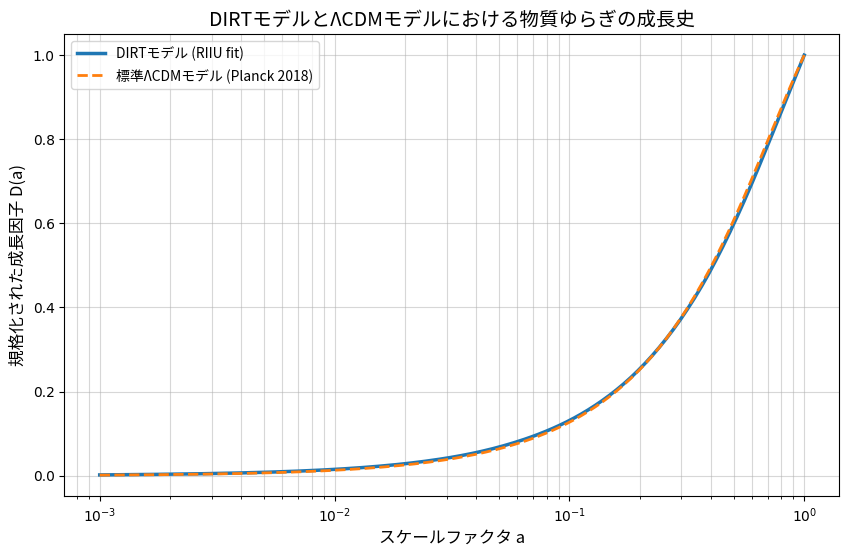

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from scipy.integrate import quad
from scipy.integrate import solve_ivp

# Japanese Font Settings (Run this block if you are in a Colab-like environment)
# 日本語フォント設定（Colabなどの環境にいる場合にこのブロックを実行）
try:
    !apt-get -y install fonts-noto-cjk -qq
    font_path = "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc"
    font_prop = fm.FontProperties(fname=font_path)
    plt.rcParams["font.family"] = font_prop.get_name()
    plt.rcParams["axes.unicode_minus"] = False
except:
    print("日本語フォントのインストールをスキップしました。ローカル環境では不要な場合があります。")

# ===== Step 2: Calculation of Matter Perturbation Growth (Revised Version) =====
# ===== ステップ2: 物質ゆらぎの成長計算 (修正版) =====

# --- Physical Constants and Model Parameters (RIIU Version) ---
# --- 物理定数とモデルパラメータ（RIIU版） ---
c_kms = 299792.458
Omega_rad = 9.24e-5
H0 = 63.1923
Omega_m = 0.4137
A2 = 0.3118
R_early = 0.0051
R_late = 0.8950
a_trans = 0.6913
delta_a = 0.2622
Gamma0 = 0.0578

# --- Core Function of the DIRT Model (Reposted) ---
# --- DIRTモデルのコア関数（再掲） ---
def p2(cos_theta):
    return 0.5 * (3 * cos_theta**2 - 1)

def r_iso_transition_model(a, R_early_val, R_late_val, a_trans_val, delta_a_val):
    return R_late_val + (R_early_val - R_late_val) * 0.5 * (1 - np.tanh((a - a_trans_val) / delta_a_val))

def hubble_parameter_interaction(z, cos_theta=1.0):
    a = 1.0 / (1.0 + z)
    Omega_L = 1.0 - Omega_m - Omega_rad
    # For background evolution, we use the isotropic part of R_lock
    # 背景進化の計算では、R_lockの等方成分を用いる
    r_iso = r_iso_transition_model(a, R_early, R_late, a_trans, delta_a)
    # The anisotropic part is averaged over. For the growth equation, we need the angle-averaged H(z)
    # 異方性部分は角度平均される。成長方程式には角度平均したH(z)が必要。
    r_lock = np.maximum(0, r_iso * (1 + A2 * p2(cos_theta)))
    interaction_gamma = Gamma0 * (1.0 - r_lock)
    matter_term = (Omega_m / a**3) * (a**(3 * interaction_gamma))
    h2 = (Omega_rad / a**4) + matter_term + Omega_L
    if h2 < 0: return np.inf
    return H0 * np.sqrt(h2)

# --- Standard ΛCDM Model for Comparison (Reposted) ---
# --- 比較用の標準ΛCDMモデル（再掲） ---
def hubble_parameter_lcdm(z, H0_lcdm=67.4, Omega_m_lcdm=0.315):
    a = 1.0 / (1.0 + z)
    Omega_L_lcdm = 1.0 - Omega_m_lcdm - Omega_rad
    h2 = (Omega_rad / a**4) + (Omega_m_lcdm / a**3) + Omega_L_lcdm
    return H0_lcdm * np.sqrt(h2)

# --- Create a Table of Angle-Averaged H(z) Calculations ---
# --- 角度平均したH(z)の計算テーブルを作成 ---
a_vals_for_H_table = np.logspace(-4, 0, 200)
# Integrate H^2 over cos(theta) from 0 to 1, as P2 is an even function.
# P2は偶関数なので、cos(theta)について0から1まで積分する
H2_avg_table = np.array([quad(lambda ct: hubble_parameter_interaction(1.0/a - 1.0, ct)**2, 0, 1)[0] for a in a_vals_for_H_table])

def get_H_avg(a):
    """Interpolate from the pre-computed table to get the angle-averaged H(a)"""
    """事前計算テーブルから補間して角度平均したH(a)を取得"""
    return np.sqrt(np.interp(a, a_vals_for_H_table, H2_avg_table))

# --- Define the Growth Equation of Perturbations ---
# --- ゆらぎの成長方程式を定義 ---
def growth_ode(a, y, model_type='DIRT'):
    H_val = get_H_avg(a) if model_type == 'DIRT' else hubble_parameter_lcdm(1/a - 1)

    # For simplicity, approximate the H’ term using numerical differences
    # 簡単のため、H'の項は数値差分で近似
    delta = 1e-6
    a_plus = a + delta
    a_minus = a - delta if a > delta else a/2.

    H_plus = get_H_avg(a_plus) if model_type == 'DIRT' else hubble_parameter_lcdm(1/a_plus - 1)
    H_minus = get_H_avg(a_minus) if model_type == 'DIRT' else hubble_parameter_lcdm(1/a_minus - 1)
    H_prime = (H_plus - H_minus) / (a_plus - a_minus)

    # Compute the Effective Omega_m(a) for the background
    # 背景の有効なOmega_m(a)の計算
    if model_type == 'DIRT':
        # The effective matter density in the background is angle-averaged.
        # This simplifies to using the isotropic r_iso for the gamma term.
        # 背景の有効な物質密度は角度平均される。これはガンマ項に等方的なr_isoを用いることで簡略化される。
        r_iso_val = r_iso_transition_model(a, R_early, R_late, a_trans, delta_a)
        interaction_gamma_iso = Gamma0 * (1.0 - r_iso_val)
        Omega_m_a_eff = (Omega_m / a**3) * (a**(3 * interaction_gamma_iso))
        Omega_m_eff_at_a = Omega_m_a_eff / (H_val**2 / H0**2)

    else: # LCDM
        Omega_m_lcdm = 0.315
        Omega_m_a_eff = Omega_m_lcdm / a**3
        Omega_m_eff_at_a = Omega_m_a_eff / (hubble_parameter_lcdm(1/a - 1)**2 / 67.4**2)


    dD_da = y[1]
    d2D_da2 = -(3./a + H_prime / H_val) * y[1] + (1.5 * Omega_m_eff_at_a / a**2) * y[0]

    return [dD_da, d2D_da2]

# --- Solve the Differential Equation ---
# --- 微分方程式を解く ---
a_init = 1e-3
a_span = [a_init, 1.0]
a_eval = np.logspace(np.log10(a_init), 0, 200)

# DIRT Model
# DIRTモデル
y_init = [a_init, 1.0] # Initial conditions D(a) ~ a
sol_dirt = solve_ivp(lambda a, y: growth_ode(a, y, 'DIRT'), a_span, y_init, t_eval=a_eval, method='RK45')
D_a_dirt = sol_dirt.y[0] / sol_dirt.y[0][-1] # Normalize to D(a=1) = 1 # D(a=1)=1に規格化

# ΛCDM Model
# ΛCDMモデル
sol_lcdm = solve_ivp(lambda a, y: growth_ode(a, y, 'LCDM'), a_span, y_init, t_eval=a_eval, method='RK45')
D_a_lcdm = sol_lcdm.y[0] / sol_lcdm.y[0][-1] # Normalize to D(a=1) = 1 # D(a=1)=1に規格化

# --- Plot the Results ---
# --- 結果をプロット ---
plt.figure(figsize=(10, 6))
plt.plot(sol_dirt.t, D_a_dirt, label='DIRTモデル (RIIU fit)', lw=2.5)
plt.plot(sol_lcdm.t, D_a_lcdm, label='標準ΛCDMモデル (Planck 2018)', lw=2, linestyle='--')
plt.xscale('log')
plt.xlabel('スケールファクタ a', fontproperties=font_prop, fontsize=12)
plt.ylabel('規格化された成長因子 D(a)', fontproperties=font_prop, fontsize=12)
plt.title('DIRTモデルとΛCDMモデルにおける物質ゆらぎの成長史', fontproperties=font_prop, fontsize=14)
plt.legend(prop=font_prop)
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.show()

In [8]:
import numpy as np
import emcee

# — Definition of Parameters and Number of Data Points —
# --- パラメータとデータ数の定義 ---
k_dirt = 9  # Number of Parameters in the DIRT Model (H₀, Ωₘ, A₂, R_early, R_late, a_trans, Δa, Γ₀, M)
n_total = 1707 # Total Number of Data Points (SNe: 1701 + BAO: 6)

# — Load MCMC Results (RIIU version with prior) —
# --- MCMC結果の読み込み (RIIU版・事前分布あり) ---
mcmc_filename = "joint_sne_bao_R_early_prior_backend.h5"
try:
    # Use the filename for the analysis with the R_early prior
    # R_early事前分布ありの解析のファイル名を使用
    backend_dirt = emcee.backends.HDFBackend(mcmc_filename, read_only=True)

    # Retrieve the Maximum Log-Likelihood from the Entire Chain
    # チェーン全体から対数確率の最大値を取得
    log_prob_dirt = backend_dirt.get_log_prob()
    log_L_max_dirt = np.max(log_prob_dirt)

    if not np.isfinite(log_L_max_dirt):
        raise ValueError("対数尤度の最大値が有効な数値ではありません。")

    # — Calculation of AIC and BIC —
    # --- AICとBICの計算 ---
    aic_dirt = 2 * k_dirt - 2 * log_L_max_dirt
    bic_dirt = k_dirt * np.log(n_total) - 2 * log_L_max_dirt

    print("--- DIRT相互作用モデル (R_early事前分布あり) の評価 ---")
    print(f"読み込みファイル: {mcmc_filename}")
    print(f"パラメータ数 (k): {k_dirt}")
    print(f"データ点数 (n): {n_total}")
    print(f"最大対数尤度 ln(L_max): {log_L_max_dirt:.4f}")
    print(f"AIC: {aic_dirt:.4f}")
    print(f"BIC: {bic_dirt:.4f}")

except FileNotFoundError:
    print(f"エラー: MCMCバックエンドファイル '{mcmc_filename}' が見つかりません。")
except Exception as e:
    print(f"エラーが発生しました: {e}")

--- DIRT相互作用モデル (R_early事前分布あり) の評価 ---
読み込みファイル: joint_sne_bao_R_early_prior_backend.h5
パラメータ数 (k): 9
データ点数 (n): 1707
最大対数尤度 ln(L_max): -995.6996
AIC: 2009.3993
BIC: 2058.3817
